# Baselines for Deep Learning Approaches

In this notebook, simple baselines are established for wildfire, landslides and floods using Random Forest Regression. The results will later be compared against the deep learning performance to establish the improvement relative to simple machine learning methods.

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump, load


from sklearn.ensemble import RandomForestRegressor,  RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc, mean_absolute_error, r2_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

plt.style.use('bauhaus_light')


In [3]:
!pwd

/Users/jeremypalmerio/Repos/MasterThesis


To develop the framwork for the baseline, the wildfire hazard is chosen as it is ready at this point. The framework should be identical for the floods and landslides as well, so when the labeled dataset is ready, their respective baselines will be run as well.

In [4]:
# files to : load temperature_daily, NDVI, landcover, elevation, wind_speed, fire_weather, soil_moisture(root or surface)
hazard = "wildfire"

# List your file paths
signal_paths = [
    "Input/Europe/downsampled_arrays/masked_NDVI_Europe_flat_downsampled.npy",
    "Input/Europe/downsampled_arrays/masked_temperature_daily_Europe_downsampled.npy",
    "Input/Europe/downsampled_arrays/masked_landcover_Europe_flat_downsampled.npy",
    "Input/Europe/downsampled_arrays/masked_elevation_Europe_downsampled.npy",
    "Input/Europe/downsampled_arrays/masked_wind_speed_daily_Europe_downsampled.npy",
    "Input/Europe/downsampled_arrays/masked_fire_weather_Europe_downsampled.npy",
    "Input/Europe/downsampled_arrays/masked_soil_moisture_surface_Europe_downsampled.npy",
]

# Load them into a feature matrix
X = np.stack([np.load(p) for p in signal_paths], axis=1)  # shape: [num_samples, num_features]

# Load the wildfire counts at those same sampled points
wildfire_counts = np.load("Input/Europe/downsampled_arrays/masked_wildfire_Europe_downsampled.npy").astype(float)

In [5]:
# shapes of the data
print("X shape:", X.shape)
print("wildfire_counts shape:", wildfire_counts.shape)
# Check for NaN values in the features and target
print("NaN values in features:", np.isnan(X).sum())
print("NaN values in target:", np.isnan(wildfire_counts).sum())

# Remove cells with NaN values in the features or target
valid_mask = ~np.isnan(X).any(axis=1) & ~np.isnan(wildfire_counts)
X = X[valid_mask]
wildfire_counts = wildfire_counts[valid_mask]
print("X shape after removing NaNs:", X.shape)
print("wildfire_counts shape after removing NaNs:", wildfire_counts.shape)



X shape: (2103439, 7)
wildfire_counts shape: (2103439,)
NaN values in features: 376024
NaN values in target: 0
X shape after removing NaNs: (1840270, 7)
wildfire_counts shape after removing NaNs: (1840270,)


Some inputs are showing NaNs values, this is likely an error from the preporcessing steps for the fire_weather signal, however for the soil moisture this appears to be native, and should probably be filled in the future instead of dropped. For the moment being, as this a simple baseline test, the NaNs are dropped. 

## Classification

First, the problem is modeled as a binary classification exercise, where the counts are normalized between [0, 1] to represent a sort of likelihood, and a threshold is applied to seperate "low likelihood" and "high likelihood" cells as class 0 and 1 respectively. 

In [6]:
threshold = 0
y = (wildfire_counts > threshold).astype(int)


print(f"Label breakdown: {np.bincount(y)}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Train label breakdown: {np.bincount(y_train)}, Test label breakdown: {np.bincount(y_test)}")


Label breakdown: [1702542  137728]
Train label breakdown: [1362348  109868], Test label breakdown: [340194  27860]


A noticeable class imbalance arrises from this processing, wherein the "low likelihood" class is around 10x more common than the "high likelihood" class. To deal with this, the over represented class is undersampled such that the training set contains equal proportions of each class.

In [7]:
from sklearn.utils import resample
# Balancing classes 

# Separate the majority and minority classes
class_0_indices = np.where(y_train == 0)[0]
class_1_indices = np.where(y_train == 1)[0]

# Downsample the majority class (class 0) to match the size of the minority class (class 1)
class_0_downsampled = resample(
    class_0_indices,
    replace=False,  # No replacement, we want to downsample
    n_samples=len(class_1_indices),  # Match the number of class 1 samples
    random_state=42  # For reproducibility
)

# Combine the downsampled majority class with the minority class
balanced_indices = np.concatenate([class_0_downsampled, class_1_indices])

# Shuffle the indices to mix the classes
np.random.shuffle(balanced_indices)

# Create the balanced training set
X_train = X_train[balanced_indices]
y_train = y_train[balanced_indices]

print(f"Train label breakdown: {np.bincount(y_train)}, Test label breakdown: {np.bincount(y_test)}")


Train label breakdown: [109868 109868], Test label breakdown: [340194  27860]


In [29]:
# Random Forest Clasfifier 

# clf = RandomForestClassifier(
#     n_estimators=100,
#     max_depth=10,             # Limit tree depth
#     min_samples_split=10,     # Avoid overfitting on tiny splits
#     min_samples_leaf=5,       # Each leaf must have at least 5 samples
#     random_state=42,
#     n_jobs=-1
# )

# clf.fit(X_train, y_train)

# # Save model
# dump(clf, f"Baseline/models/{hazard}_RF_classification_baseline.joblib")

clf_RF = load(f"Baseline/models/{hazard}_RF_classification_baseline.joblib")


In [30]:
from sklearn.neural_network import MLPClassifier

# MLP Classifier 

# clf = MLPClassifier(
#         hidden_layer_sizes=(150, 100, 75, 50),  # Two hidden layers with 100 and 50 neurons
#         activation='relu',              # ReLU activation function
#         solver='adam',                  # Adam optimizer
#         alpha=0.0001,                   # L2 regularization
#         batch_size='auto',              # Automatic batch size
#         learning_rate='adaptive',       # Adaptive learning rate
#         learning_rate_init=0.001,       # Initial learning rate
#         max_iter=100,              # Maximum number of iterations
#         early_stopping=True,            # Use early stopping
#         validation_fraction=0.1,        # Fraction of training data for validation
#         n_iter_no_change=10,            # Early stopping patience
#         random_state=42,
#         verbose=True
#     )

# clf.fit(X_train, y_train)

# # Save model
# dump(clf, f"Baseline/models/{hazard}_MLP_classification_baseline.joblib")

clf_MLP = load(f"Baseline/models/{hazard}_MLP_classification_baseline.joblib")


In [246]:
from IPython.display import display, HTML

display(HTML('''
    <style>
        img {
            display: block;
            margin-left: auto;
            margin-right: auto;
            max-width: 800px !important;
            height: auto;
        }
    </style>
'''))

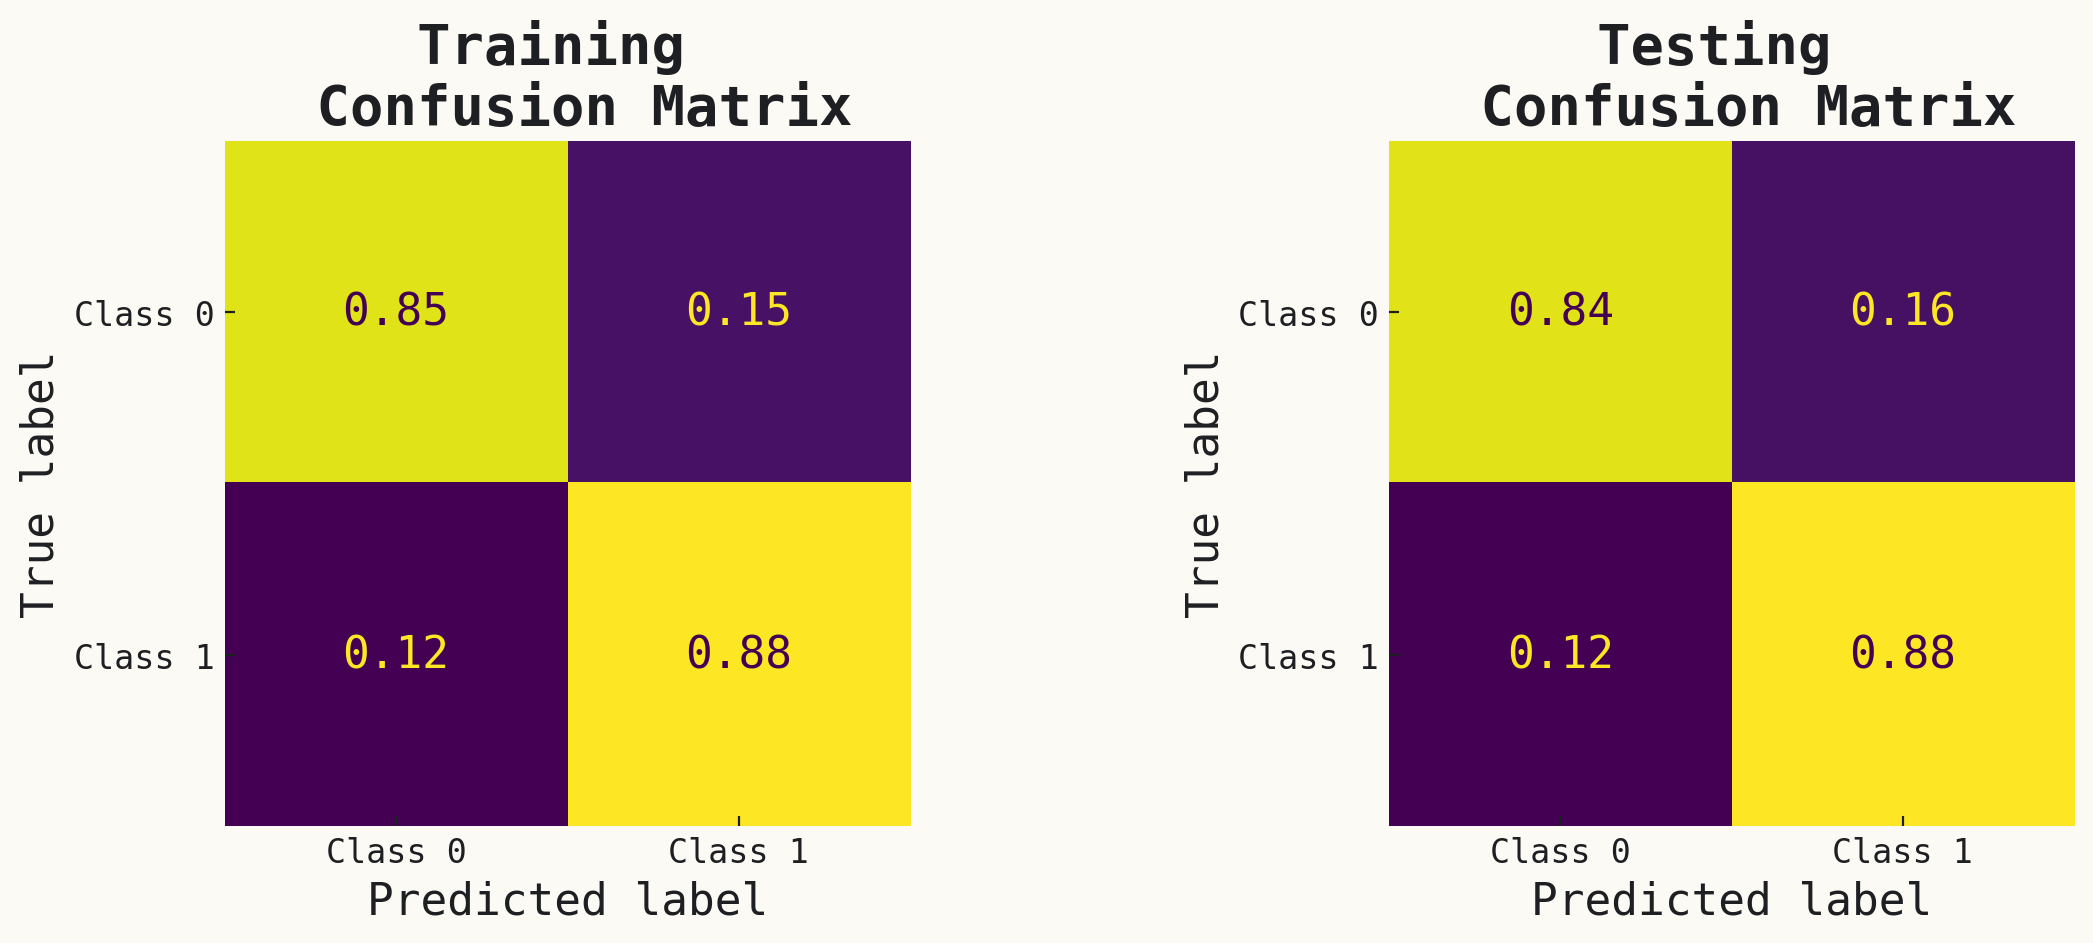

In [45]:
clf = clf_MLP
# Predictions
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

# Confusion Matrices
train_cm = confusion_matrix(y_train, y_train_pred, normalize='true')
test_cm = confusion_matrix(y_test, y_test_pred, normalize='true')

# Plot Confusion Matrices
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ConfusionMatrixDisplay(train_cm, display_labels=["Class 0", "Class 1"]).plot(ax=ax[0], colorbar=False)
ax[0].set_title("Training \n Confusion Matrix")
ConfusionMatrixDisplay(test_cm, display_labels=["Class 0", "Class 1"]).plot(ax=ax[1], colorbar=False)
ax[1].set_title("Testing \n Confusion Matrix")
plt.tight_layout()
plt.show()

The performance of the classification is shown in the confusion matrices for the training and testing sets. Training and testing performance are very similar which implies little overfitting, and both show high TN and TP rates of 0.85 and 0.91 respectively.

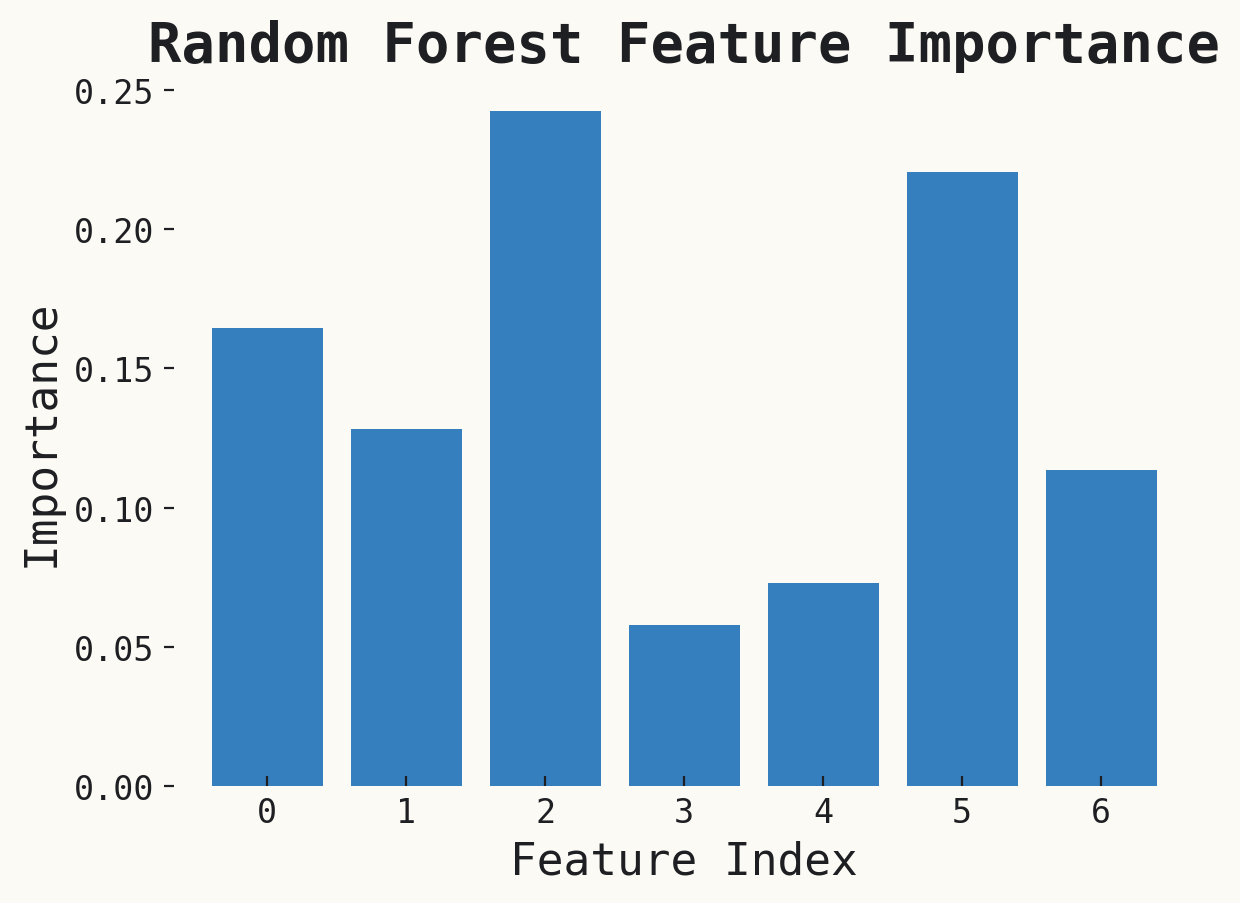

In [27]:
importances = clf.feature_importances_
plt.bar(range(X.shape[1]), importances)
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.title("Random Forest Feature Importance")

plt.show()

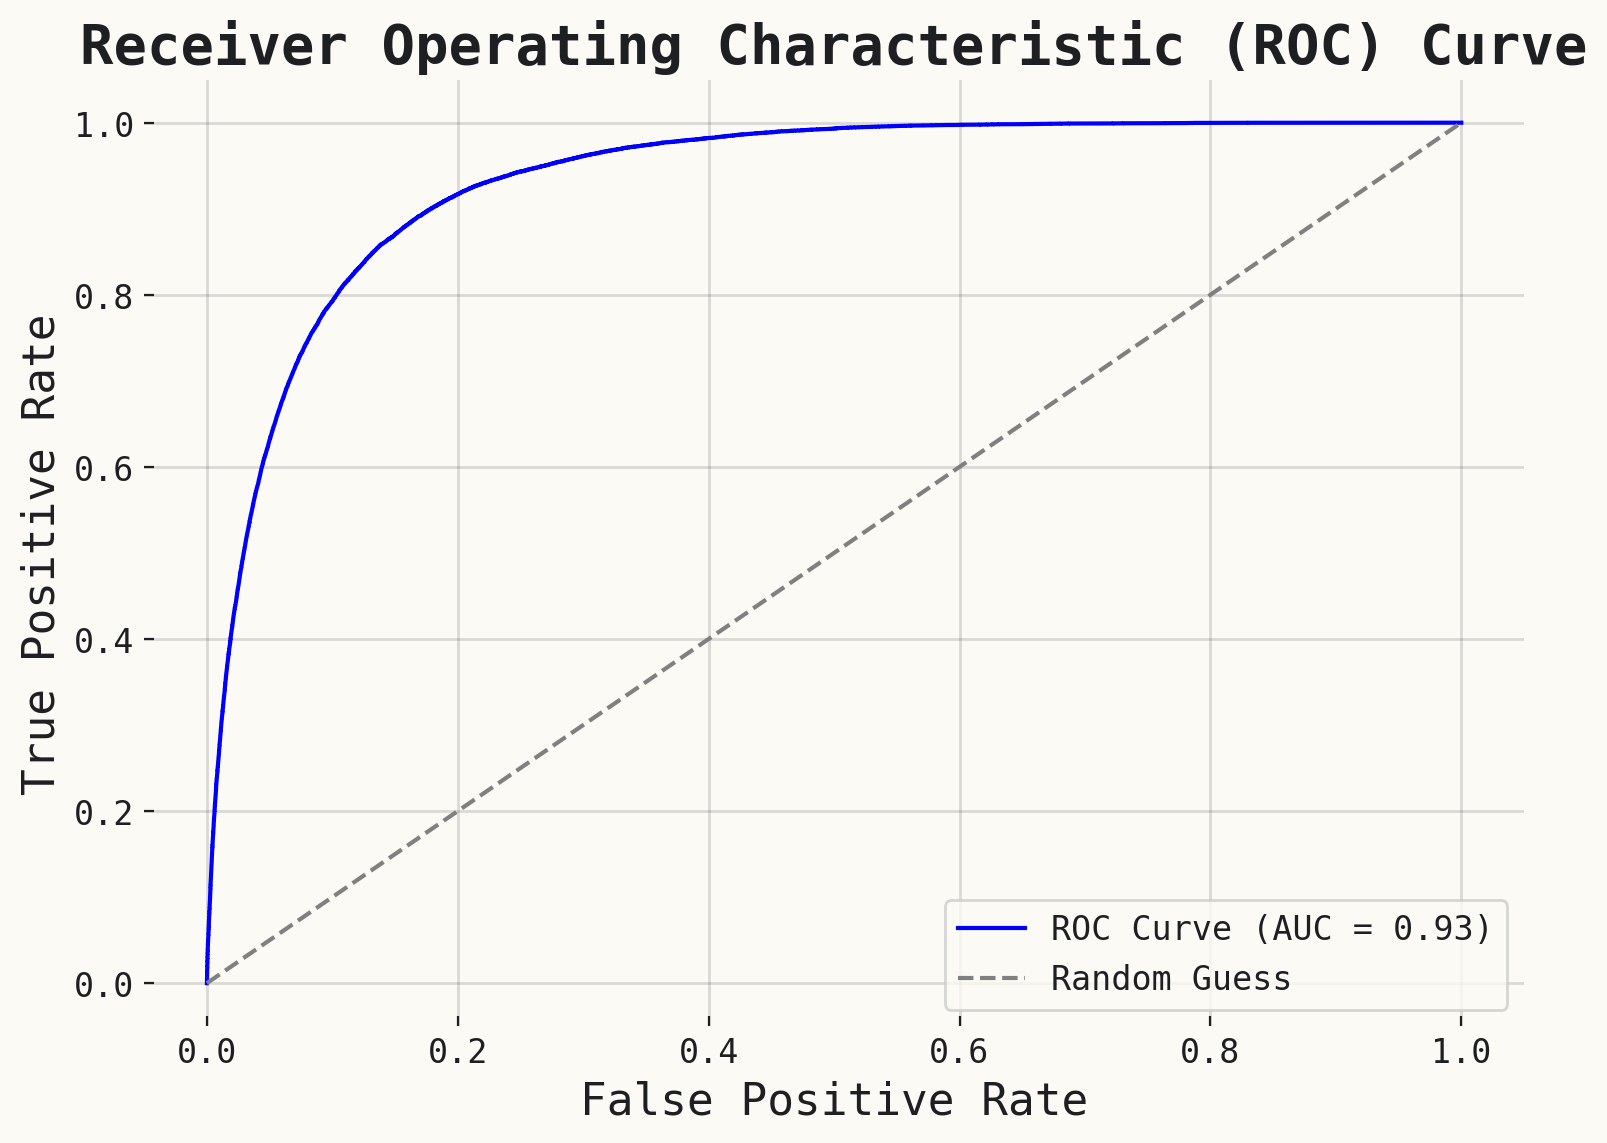

Best Threshold: 0.53
F1 Score: 0.46
F1 Score (with best threshold): 0.48


In [46]:
# ROC Curve
from sklearn.metrics import f1_score


y_test_proba = clf.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

# Find the best threshold (closest to the top-left corner)
distances = np.sqrt((1 - tpr)**2 + fpr**2)  # Euclidean distance to (0, 1)
best_threshold_index = np.argmin(distances)
best_threshold = thresholds[best_threshold_index]

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

print(f"Best Threshold: {best_threshold:.2f}")
print(f"F1 Score: {f1_score(y_test, y_test_pred):.2f}")
print(f"F1 Score (with best threshold): {f1_score(y_test, y_test_proba > best_threshold):.2f}")



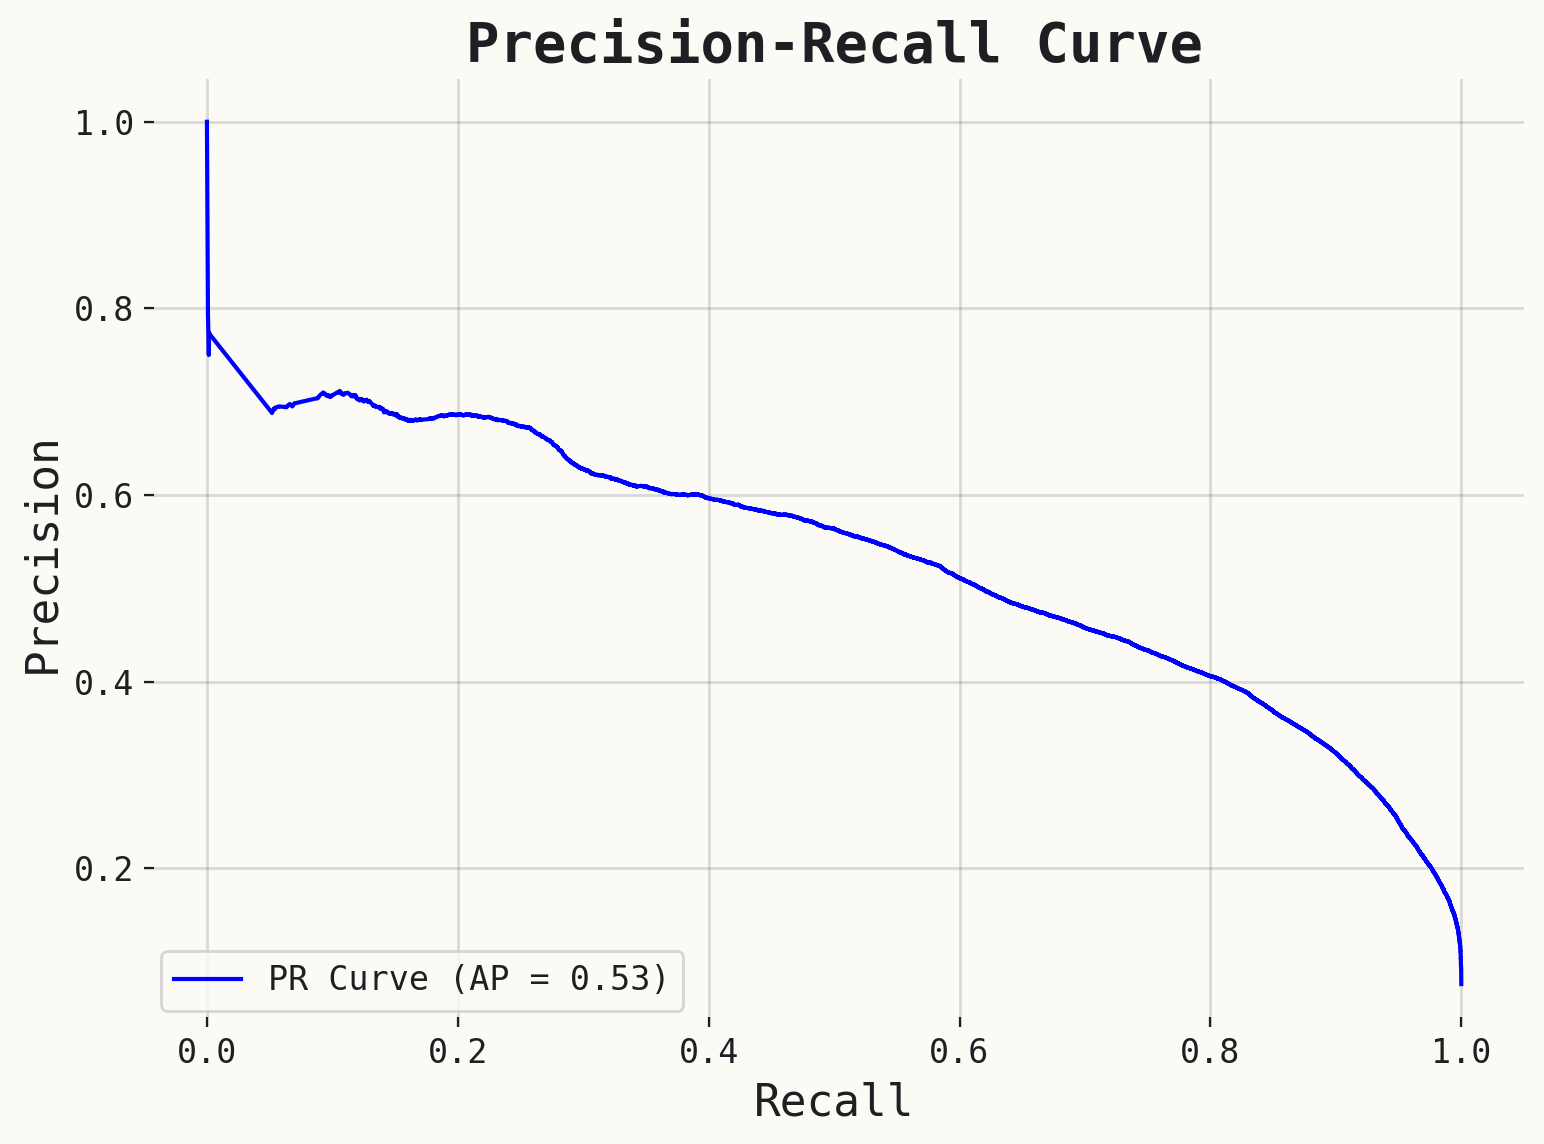

In [44]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np

# Get predicted probabilities for the positive class
y_test_proba = clf.predict_proba(X_test)[:, 1]

# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_test_proba)

# Calculate the average precision score (AUC for PR curve)
average_precision = average_precision_score(y_test, y_test_proba)

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', label=f"PR Curve (AP = {average_precision:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.grid()
plt.show()



In [42]:
from sklearn.metrics import f1_score, precision_score, recall_score

# F1 debugging 
# Get predictions using 0.5 threshold
y_pred = (clf.predict_proba(X_test)[:, 1] >= 0.8).astype(int)

# Calculate metrics using sklearn
sklearn_precision = precision_score(y_test, y_pred)
sklearn_recall = recall_score(y_test, y_pred)
sklearn_f1 = f1_score(y_test, y_pred)

# Calculate metrics manually
tp = np.sum((y_test == 1) & (y_pred == 1))
fp = np.sum((y_test == 0) & (y_pred == 1))
fn = np.sum((y_test == 1) & (y_pred == 0))

manual_precision = tp / (tp + fp) if (tp + fp) > 0 else 0
manual_recall = tp / (tp + fn) if (tp + fn) > 0 else 0
manual_f1 = 2 * (manual_precision * manual_recall) / (manual_precision + manual_recall) if (manual_precision + manual_recall) > 0 else 0

# Print all values for comparison
print(f"True Positives: {tp}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print("\nSklearn Metrics:")
print(f"Precision: {sklearn_precision:.4f}")
print(f"Recall: {sklearn_recall:.4f}")
print(f"F1 Score: {sklearn_f1:.4f}")
print("\nManual Metrics:")
print(f"Precision: {manual_precision:.4f}")
print(f"Recall: {manual_recall:.4f}")
print(f"F1 Score: {manual_f1:.4f}")

True Positives: 16962
False Positives: 16597
False Negatives: 10898

Sklearn Metrics:
Precision: 0.5054
Recall: 0.6088
F1 Score: 0.5523

Manual Metrics:
Precision: 0.5054
Recall: 0.6088
F1 Score: 0.5523


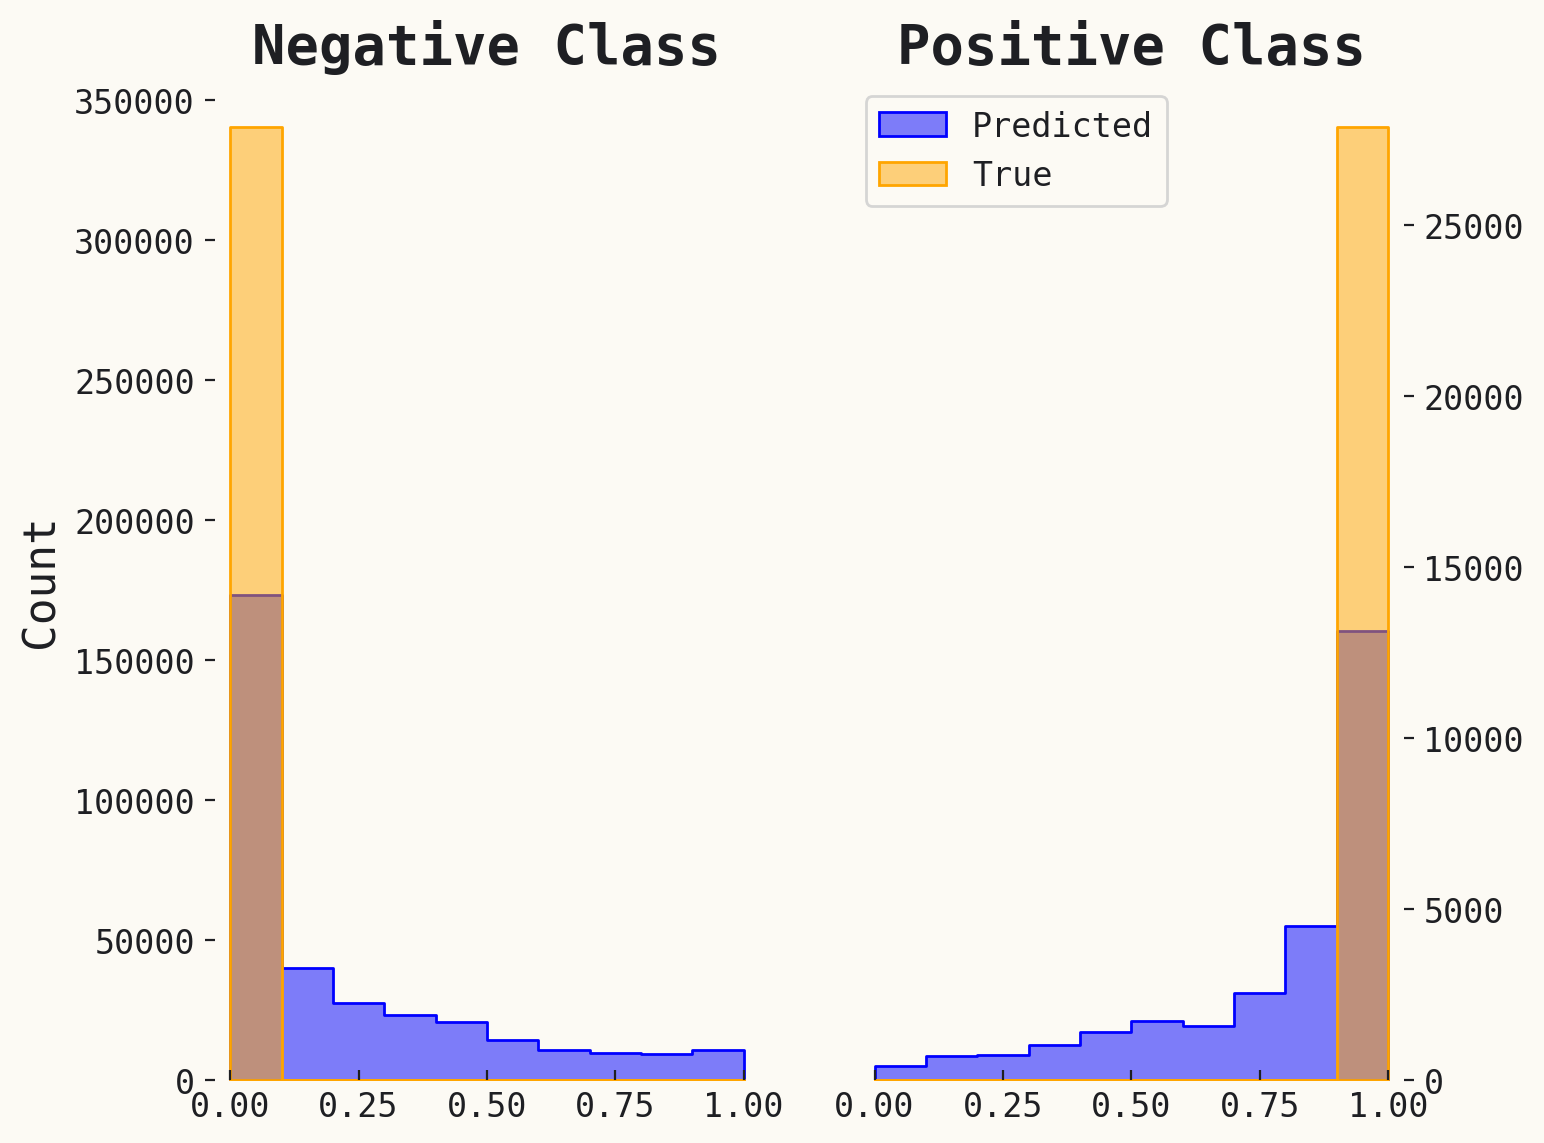

In [15]:
bin_edges = np.arange(0, 1.005, 0.05)

x = clf.predict_proba(X_test)[:, 1]
y = y_test # Wildfire counts

xy = np.concatenate((y_test.reshape(-1, 1), x.reshape(-1, 1)), axis=1)

pos = xy[xy[:, 0] == 1]
neg = xy[xy[:, 0] == 0]

fig, ax = plt.subplots(1, 2, figsize=(8, 6))
bin_edges = np.arange(0, 1.1, 0.1)
sns.histplot(neg[:, 1], bins=bin_edges, label="Predicted", color="blue", stat="count", element="step", alpha=0.5, ax=ax[0])
sns.histplot(neg[:, 0], bins=bin_edges, label="True", color="orange", stat="count", element="step", alpha=0.5, ax=ax[0])
sns.histplot(pos[:, 1], bins=bin_edges, label="Predicted", color="blue", stat="count", element="step", alpha=0.5, ax=ax[1])
sns.histplot(pos[:, 0], bins=bin_edges, label="True", color="orange", stat="count", element="step", alpha=0.5, ax=ax[1])
ax[1].set_title("Positive Class")
ax[0].set_title("Negative Class")

ax[0].set_ylabel("Count")
ax[1].set_ylabel("")

ax[1].legend()
ax[1].yaxis.tick_right()
plt.tight_layout()
plt.show()


Another performance check is done using the ROC, which shows a high AUC of 0.94 showing good performance. 


## Regression

The modelling problem can also be thought of as regression exercise, whereing the goal is to regress each cell's 'likelihood'. Posing this as a regression allows for a more fine grained interpretation of the resulting map, where thresholding can be applied later depending on the use case. This is a substantially harder problem than binary classification, so lower performance is to be expected. 


In [71]:
# Normalize wildfire count to 0–1
y = wildfire_counts / (wildfire_counts.max() + 1e-5)


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [72]:
# model = RandomForestRegressor(
#     n_estimators=100,
#     max_depth=10,             # Limit tree depth
#     min_samples_split=10,     # Avoid overfitting on tiny splits
#     min_samples_leaf=5,       # Each leaf must have at least 5 samples
#     random_state=42,
#     n_jobs=-1
# )

# model.fit(X_train, y_train)

# # Save model
# dump(model, f"Baseline/models/{hazard}_regression_baseline.joblib")


In [73]:
model = load(f"Baseline/models/{hazard}_regression_baseline.joblib")

In [74]:
# Test set predictions and evaluation

y_pred = model.predict(X_test)

print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

# Train set predictions and evaluation

y_train_pred = model.predict(X_train)

train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

print("Train MAE:", train_mae)
print("Train R²:", train_r2)

Mean Absolute Error (MAE): 0.006157953553871916
R² Score: 0.3492556459878069
Train MAE: 0.0060845896202584345
Train R²: 0.36163718458494853


The mean absolute error and $R^2$ score show similar performance between testing and trainig, which indicates low overfitting. However, the explained variance is only around 35%. 

The Random Forest feature importance shows how much each feature contributed to the overal prediction. In this case, the most important feature is revealed to be *fire_weather*, which makes sense as this an index developped for wildfire modelling. THe second best predcitor is the *landcover* signal, which describes the land use of a given cell. This also checks out, as wildfires are more likely in forest areas. 

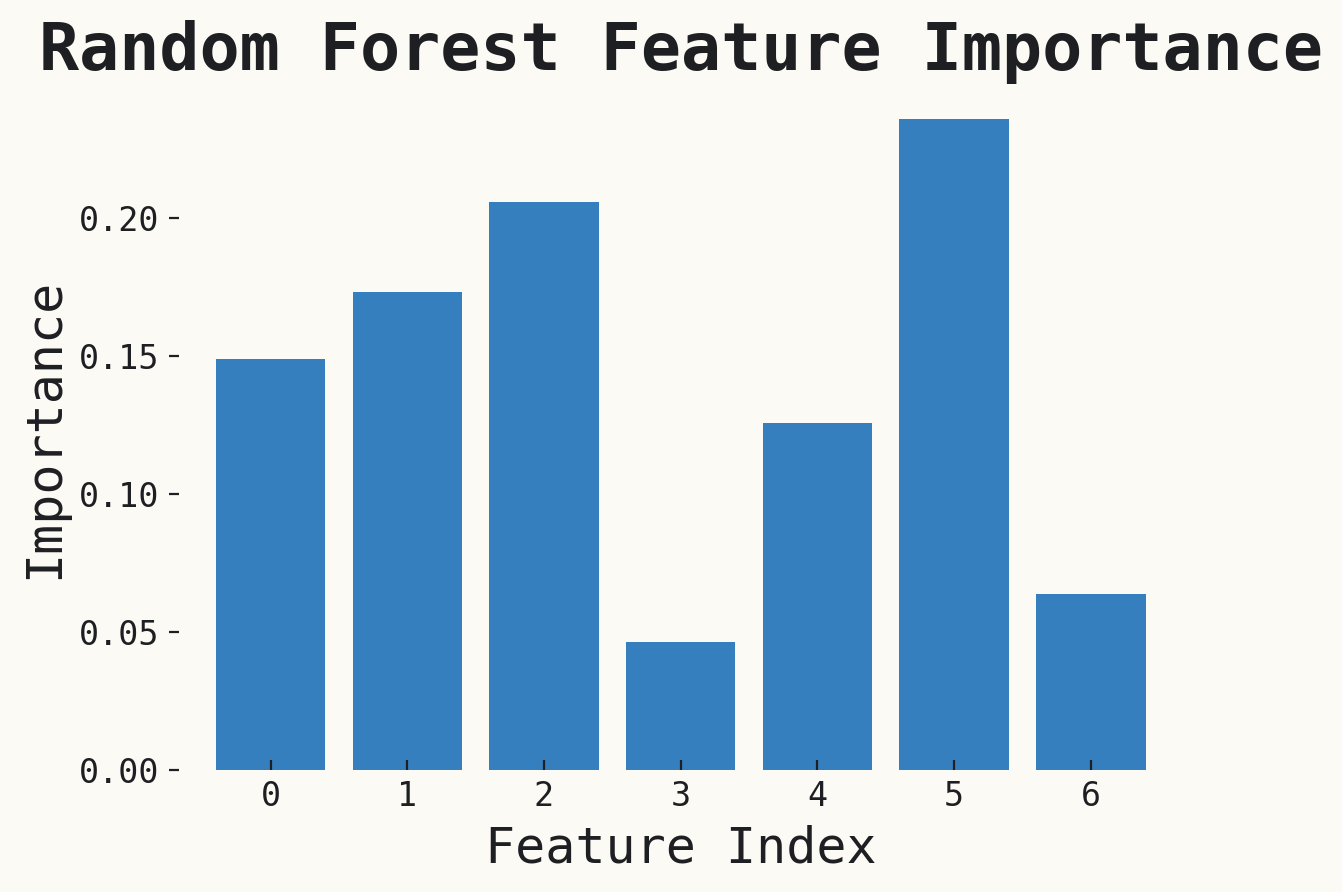

In [75]:
importances = model.feature_importances_
plt.bar(range(X.shape[1]), importances)
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.title("Random Forest Feature Importance")

plt.show()

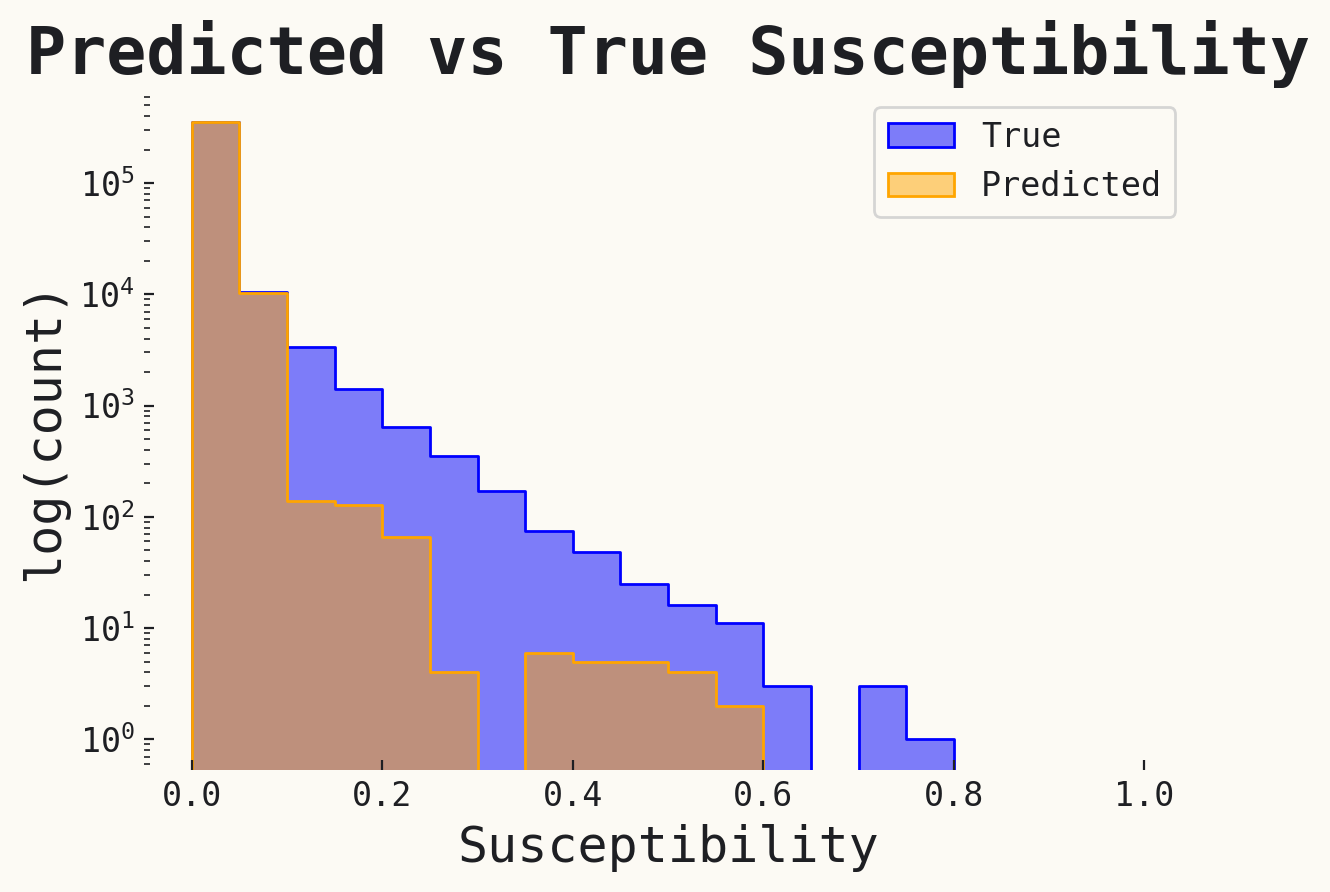

In [76]:

bin_edges = np.arange(0, 1.005, 0.05)
sns.histplot(y_test, bins=bin_edges, label="True", color="blue", stat="count", element="step", alpha=0.5)
sns.histplot(y_pred, bins=bin_edges, label="Predicted", color="orange", stat="count", element="step", alpha=0.5)

plt.yscale('log')
plt.xlabel("Susceptibility")
plt.ylabel("log(count)")
plt.title("Predicted vs True Susceptibility")
plt.legend()

plt.show()

A breakdown of the true versus predicted susceptibiliy is plotted across the susceptibiity dimesion, showing how well the model regresses each suscsptbility. First of all, the general imabalance of the data is clear, where the very low susceptibilities (around 0) are hugely over represented. the model seems to over regress cells as lower, miss identifying some of the higher end susceptibilites as low susceptibility. This is likely due to the imabalance in the data, which can be oversampled as easily as the binary case. 

**TODO: investigate balancing methods for regression** 

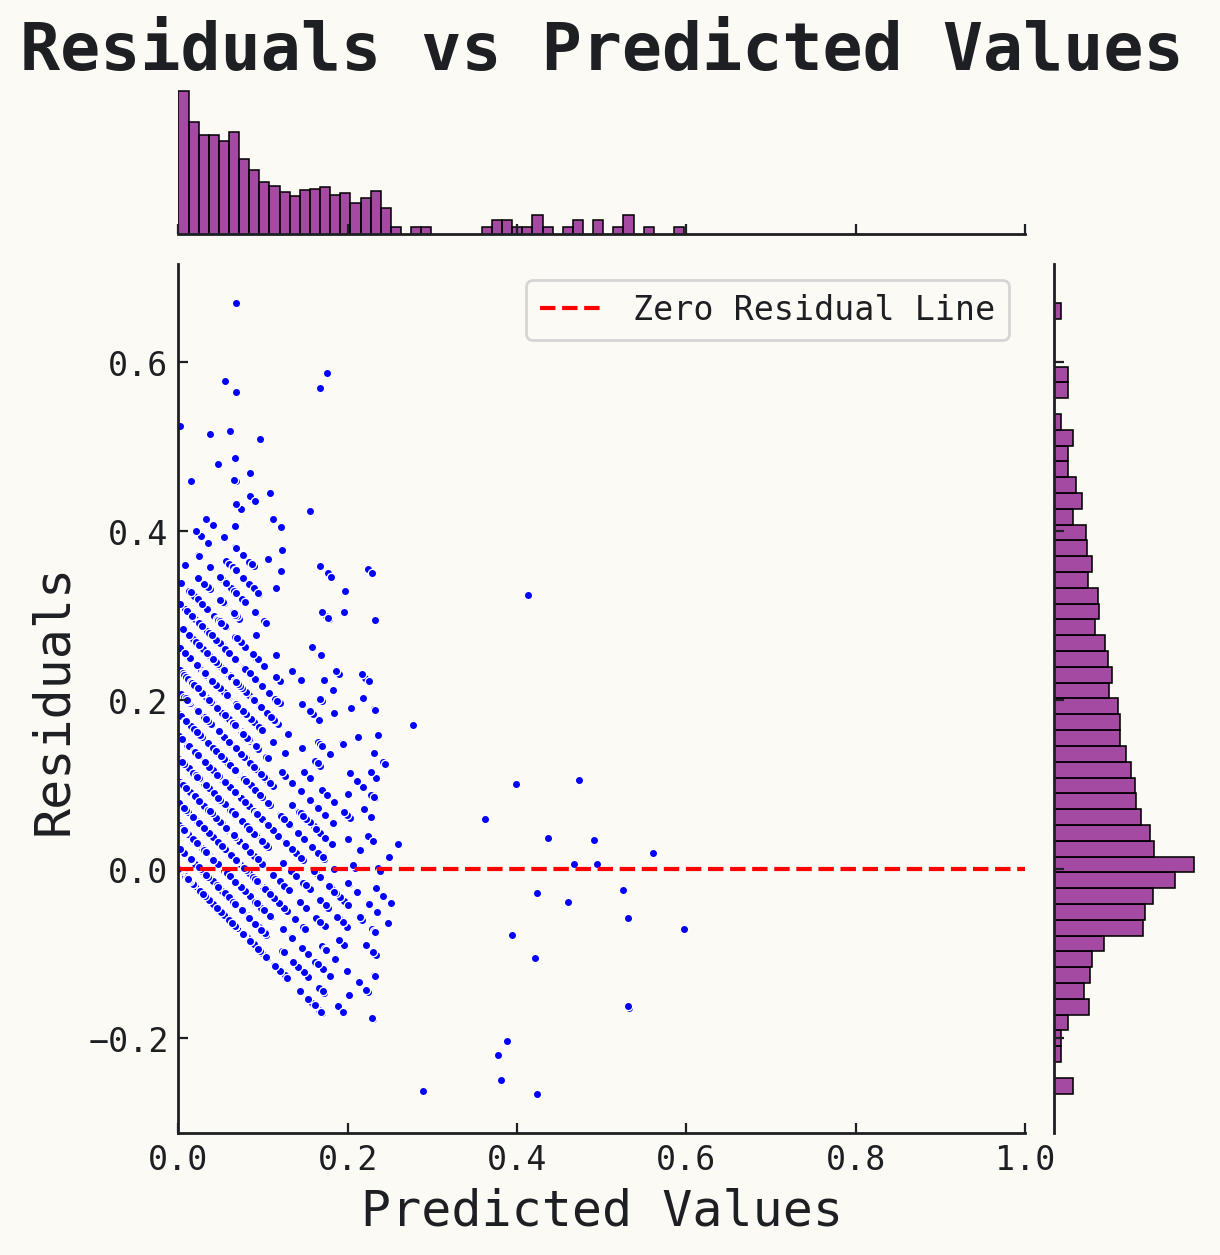

In [77]:
def plot_residuals(y_true, y_pred, bins=50):
    """
    Plots the residuals of a regression model with a joint plot.

    Parameters:
    y_true (array-like): True target values.
    y_pred (array-like): Predicted target values.
    bins (int): Number of bins for the histogram.

    Returns:
    None
    """
    # Calculate residuals
    residuals = y_true - y_pred

    # Joint plot: Residuals vs Predicted Values with marginal distributions
    joint_plot = sns.jointplot(
        x=y_pred,
        y=residuals,
        kind="scatter",
        marginal_kws=dict(bins=bins, fill=True, color="purple", alpha=0.7, ),
        color="blue",
    )
    joint_plot.ax_joint.axhline(0, color="red", linestyle="--", label="Zero Residual Line")
    joint_plot.ax_joint.set_xlabel("Predicted Values")
    joint_plot.ax_joint.set_ylabel("Residuals")
    joint_plot.ax_joint.set_title("Residuals vs Predicted Values", pad=70)
    joint_plot.ax_joint.set_xlim([0, 1])
    joint_plot.ax_joint.legend()

    joint_plot.ax_marg_x.set_yscale('log')
    joint_plot.ax_marg_y.set_xscale('log')

    plt.show()

plot_residuals(y_test, y_pred, bins=50)

**Note: the histogram along each dimesion is log-scaled to show the variation better**

Looking at the residuals confirms the suspicons laid out earlier. Most of the datapoints fall in the [0,0.3] range, and these values are consistently under estimated, with residuals largely skewed towards the positive direction, where $y_{true} >y_{pred}$.

The pattern visible in the residuals suggest variation in the label that isnt taken into account by the regression model. This suggest trying more complex methods.

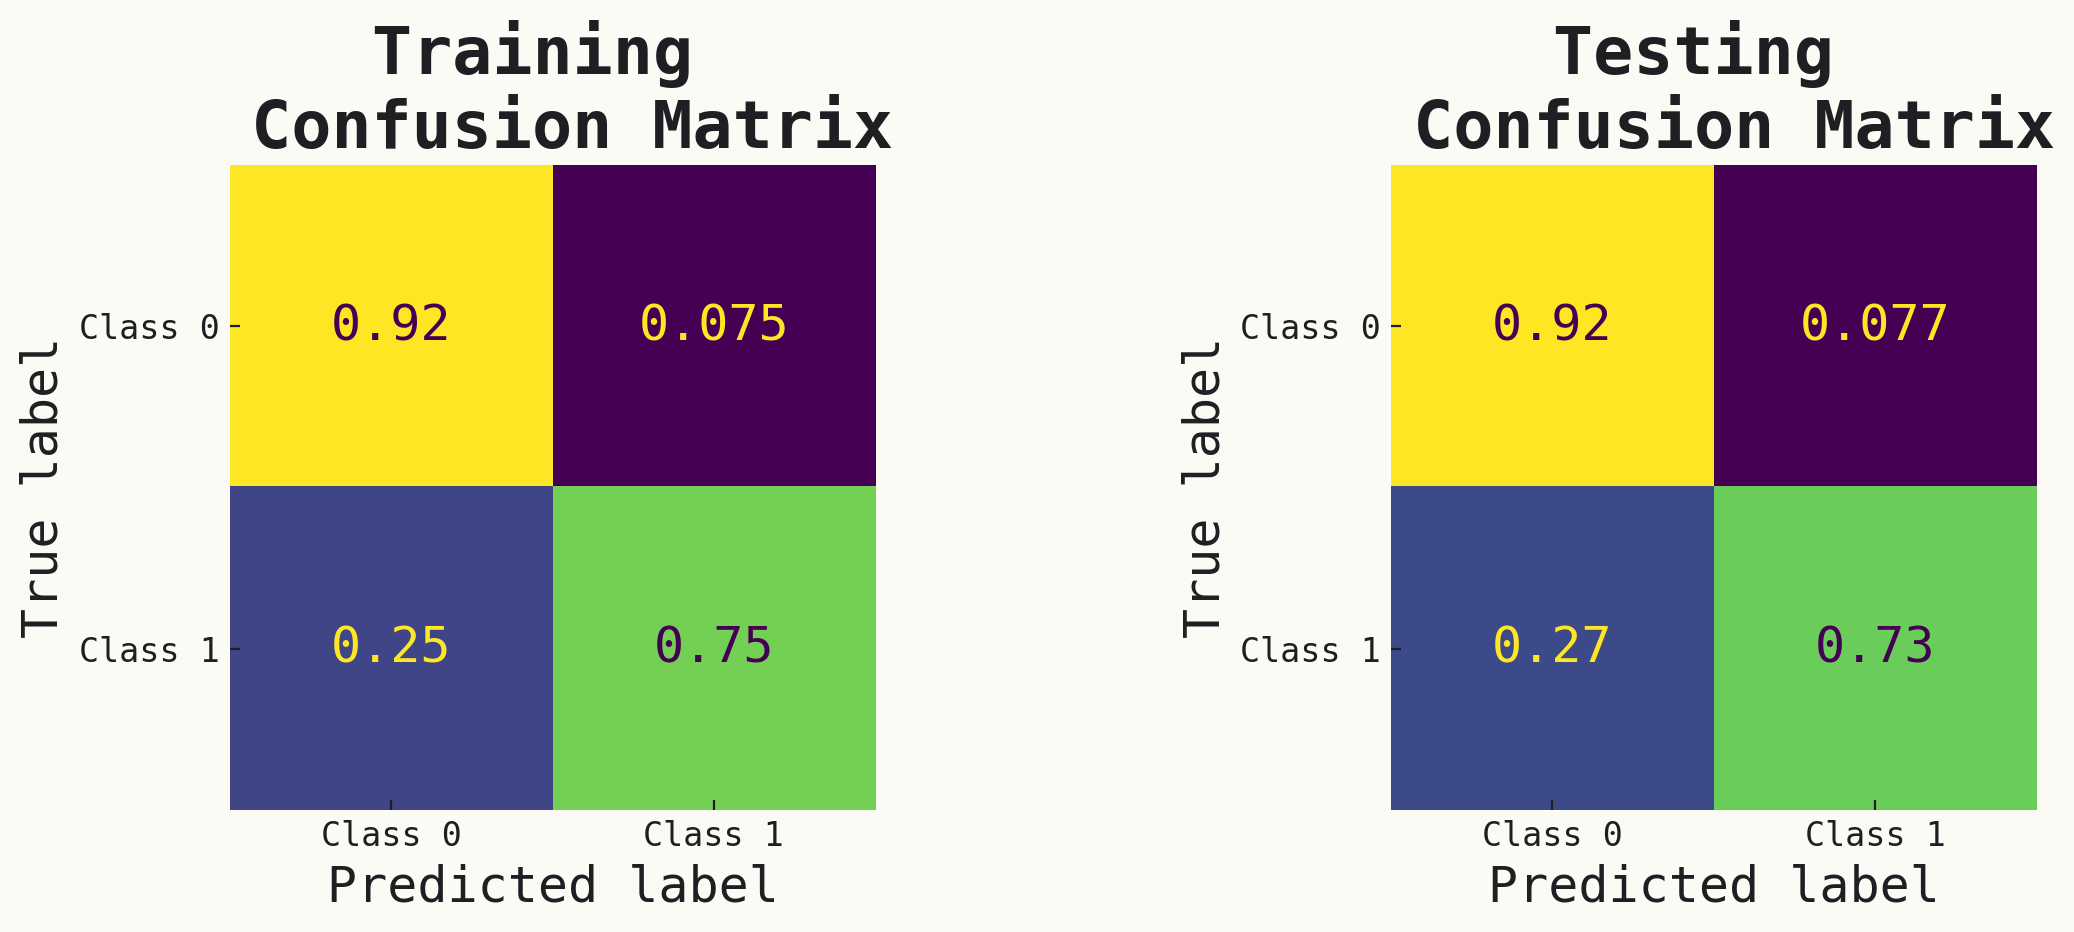

In [78]:
y_test_binary = (y_test>threshold).astype(int)
y_pred_binary = (y_pred>threshold).astype(int)

y_train_binary = (y_train>threshold).astype(int)
y_train_pred_binary = (y_train_pred>threshold).astype(int)

# Confusion Matrices
train_cm = confusion_matrix(y_train_binary, y_train_pred_binary, normalize='true')
test_cm = confusion_matrix(y_test_binary, y_pred_binary, normalize='true')

# Plot Confusion Matrices
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ConfusionMatrixDisplay(train_cm, display_labels=["Class 0", "Class 1"]).plot(ax=ax[0], colorbar=False)
ax[0].set_title("Training \n Confusion Matrix")
ConfusionMatrixDisplay(test_cm, display_labels=["Class 0", "Class 1"]).plot(ax=ax[1], colorbar=False)
ax[1].set_title("Testing \n Confusion Matrix")
plt.tight_layout()
plt.show()


By converting the regression results into a binary setup, the performance between the two methods can be compared. The confusion matrix above supports the claim made above, that higher susceptibilites are under estimated, which emerges as a lower TP and higher FP. 

The simplest explanation, is that this phenomena arrises from the skewed distribution of the label, which is over represented in the lower susceptibility range. 

## Conclusion

According to the common practice in the domain, the classification approach will be selected wherein the output of the model before thresholding is used as a proxy for susceptibility. 